In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
imNum = 1
impath = 'trash_img'
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (12, 9),
    'figure.dpi': 200

})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(X, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

In [5]:
# параметры построения графика и аппроксмации
# пользовательские параметры.
'''необходимо изменить:
название графика, 
название функции,
набор параметров с размерностями через запятую, 
указать расположение колонок с данными (stride, ...)'''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
k, $\frac{кг}{см}$
b, кг
'''
xname, xunit = r"$x$", "см"
yname, yunit = r"$y$", "кг"
stride = 5
xi = 1
yi = 0
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров
from scipy.optimize import curve_fit

0.0008024082490071249 +- 4.145695090489509e-06
18.44283917178775 +- 0.001962028926242903
0.0009338797441883973 +- 1.6354809584626539e-06
18.301984219917934 +- 0.0006993587634505556


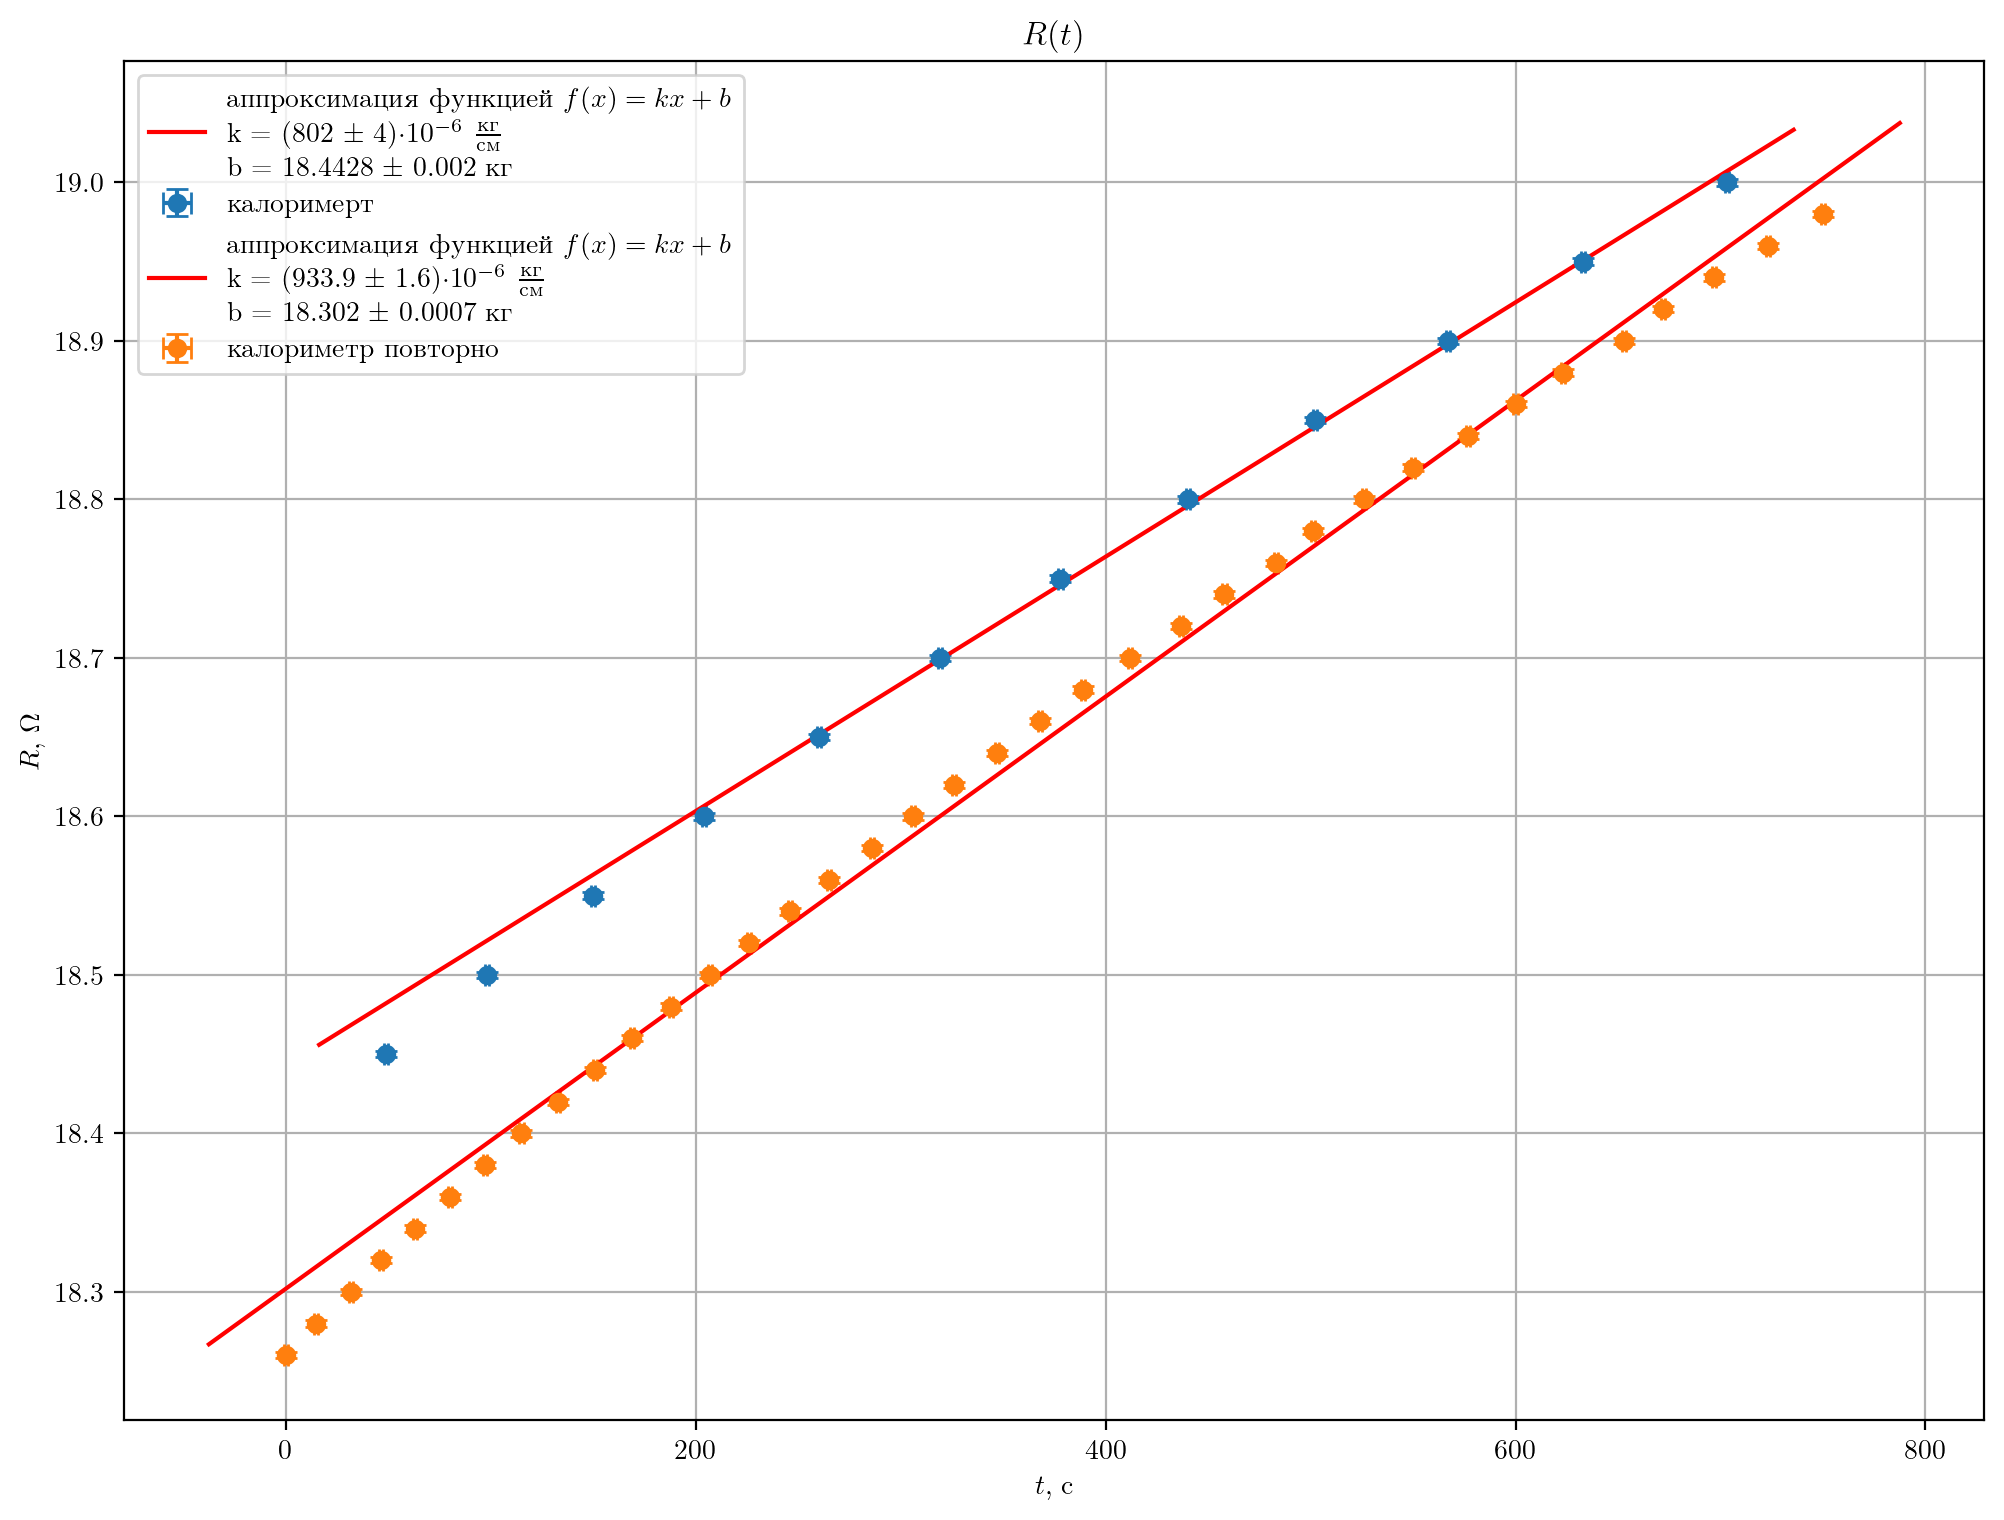

In [6]:
#Несколько графиков на одном холсте
df = pd.read_excel("multi_measurements.ods", engine="odf")
def make_graph(N):
    size = 170
    x = df.iloc[:, stride*N+xi].dropna()[:size]
    y = df.iloc[:, stride*N+yi].dropna()[:size]
    label = df.iloc[:, 5*N+4].name
    xerr = np.ones_like(x)*1
    yerr = np.ones_like(x)*0.002

    popt, pcov = curve_fit(f, x[3:], y[3:], sigma=yerr[3:], absolute_sigma=True)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)

    approx_label = f"аппроксимация функцией {fun_name}"
    par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
    for i in range(len(par_names)):
        name, units = par_names[i]
        tup = err_pres_formatter(popt[i], err[i])
        approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"

    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label=label, capsize=4, ms=6)
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError:
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

make_graph(0)
# make_graph(1)
# make_graph(2)
# make_graph(3)
make_graph(4)

plt.grid(True)
plt.xlabel(r"$t$, c")
plt.ylabel(r"$R$, $\Omega$")
plt.title(r"$R(t)$")

handles, labels = plt.gca().get_legend_handles_labels()
n = len(handles)//2
order = [i//2 if i%2==0 else n + i//2 for i in range(2*n)]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])  # labels grouped by source, not by type

plt.savefig(f"{impath}{imNum}.png", dpi=300)
imNum+=1